In [10]:
import datetime as dt

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from numbers import Number

In [11]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)
mpl.rcParams["axes.grid"] = True

In [12]:
import wmfdata as wmf
from wmfdata.utils import sig_figs

In [13]:
FILE = "metrics/metrics.tsv"

# Data loading and transformation

In [14]:
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

# Calculate other non-bot edits
# This somewhat incorrectly assumes that no mobile edits are data or upload edits 
# (or bot edits, but that's probably nearly correct). We won't be able to feasibly
# correct this until the data lake contains edit tags.
metrics["other_nonbot_edits"] = metrics["nonbot_nondata_nonupload_edits"] - metrics["mobile_edits"]

# Drop columns that aren't key metrics
metrics = metrics.drop(["nonbot_nondata_nonupload_edits"], axis=1)


# Transform content counts into content change
def stock_to_flow(arr):
    return arr[-1] - arr[0]

stock_cols = ["total_content", "wikipedia_articles", "files", "wikidata_entities"]
flow_cols = ["net_new_content", "net_new_Wikipedia_articles", "net_new_files", "net_new_Wikidata_entities"]

name_map = {stock_cols[i]: flow_cols[i] for i in range(len(stock_cols))}

flow_metrics = metrics[stock_cols].rolling(2).agg(stock_to_flow).rename(name_map, axis=1)

metrics = pd.concat([metrics, flow_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,existing_active_editors,new_active_editors,second_month_active_editors,mobile_edits,new_editor_retention,total_edits,uploads,data_edits,revert_rate,total_content,wikipedia_articles,files,wikidata_entities,other_nonbot_edits,net_new_content,net_new_Wikipedia_articles,net_new_files,net_new_Wikidata_entities
month,,,,,,,,,,,,,,,,,,,
2018-02-01,78963,58887.0,15052.0,4134.0,1011393.0,0.066915,39607703,723342,15702214,0.081981,183898889.0,47486624.0,48826383.0,46985914.0,12580849.0,3802572.0,162248.0,725534.0,2689847.0
2018-03-01,86190,63332.0,17625.0,4347.0,1121184.0,0.064066,43033263,806356,17995388,0.071150,185993282.0,47686797.0,49632489.0,47812006.0,13563855.0,2094393.0,200173.0,806106.0,826092.0
2018-04-01,83705,62042.0,16059.0,4739.0,1107284.0,0.057341,34541104,628380,12847031,0.082339,188191961.0,47859087.0,50263125.0,48959861.0,12653211.0,2198679.0,172290.0,630636.0,1147855.0
2018-05-01,85424,62698.0,17787.0,4068.0,1165558.0,NaN,39080099,738136,15706861,0.074504,191363893.0,48033215.0,51001384.0,50434708.0,13195374.0,3171932.0,174128.0,738259.0,1474847.0
2018-06-01,78549,59034.0,15005.0,3664.0,1128001.0,NaN,37112171,619140,16477748,0.066875,193057002.0,48201005.0,51626384.0,51021959.0,11876528.0,1693109.0,167790.0,625000.0,587251.0


# Report

In [15]:
def fmt_num(x):
    if isinstance(x, Number):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def pct(n):
    return "{:.1%}".format(n)

def find_latest(ser):
    nn_ser = ser[~ser.isnull()]
    return nn_ser.index[-1].date()

def calc_rpt(ser):
    nn_ser = ser[~ser.isnull()]
    cur_mo = nn_ser.index[-1].date()
    cur = nn_ser[-1]
    mo_prev = nn_ser[-2]
    yr_prev = nn_ser[-13]
    mom_change = (cur / mo_prev) - 1
    yoy_change = (cur / yr_prev) - 1
    
    res = [cur_mo, cur, mom_change, yoy_change]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["latest_month", "value", "mom_change", "yoy_change"]
    )

In [16]:
metrics.apply(calc_rpt).transpose()

,latest_month,value,mom_change,yoy_change
active_editors,2018-06-01,"78,500",-8.1%,-3.8%
existing_active_editors,2018-06-01,"59,000",-5.8%,2.0%
new_active_editors,2018-06-01,"15,000",-15.6%,-20.1%
second_month_active_editors,2018-06-01,"3,660",-9.9%,-10.9%
mobile_edits,2018-06-01,"1,130,000",-3.2%,31.9%
new_editor_retention,2018-04-01,5.7%,-10.5%,5.8%
total_edits,2018-06-01,"37,100,000",-5.0%,-3.2%
uploads,2018-06-01,"619,000",-16.1%,-31.0%
data_edits,2018-06-01,"16,500,000",4.9%,-4.7%
revert_rate,2018-06-01,6.7%,-10.2%,-20.3%


# Graphs

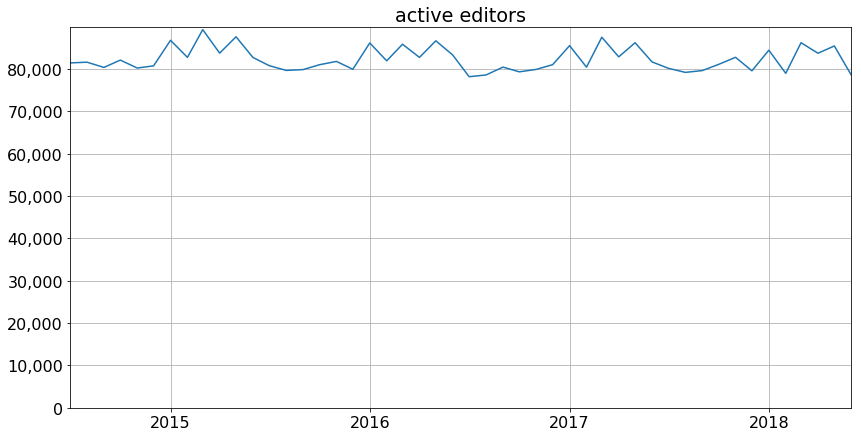

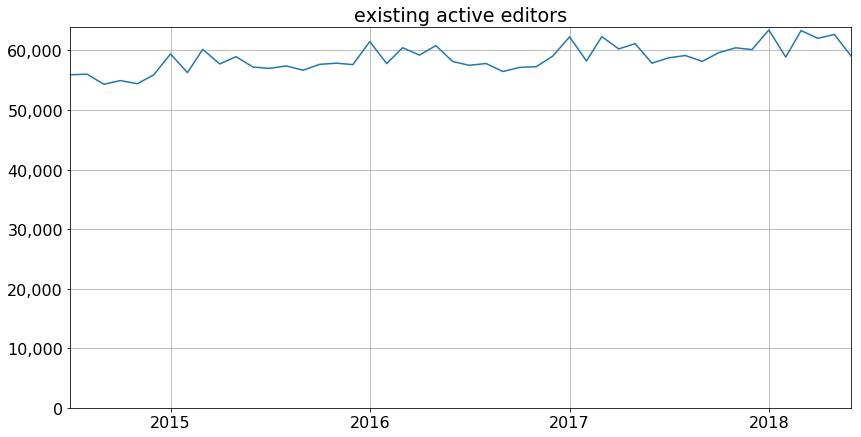

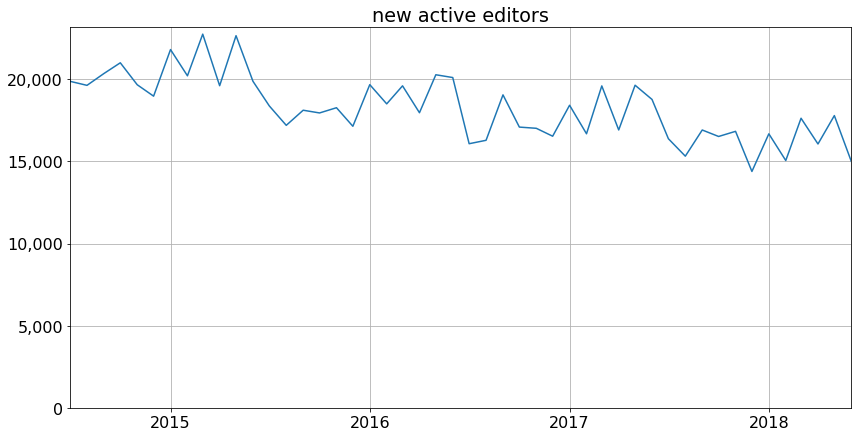

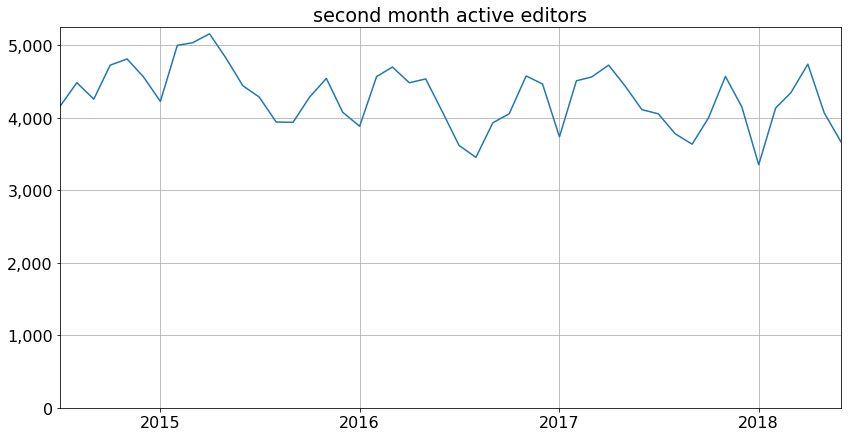

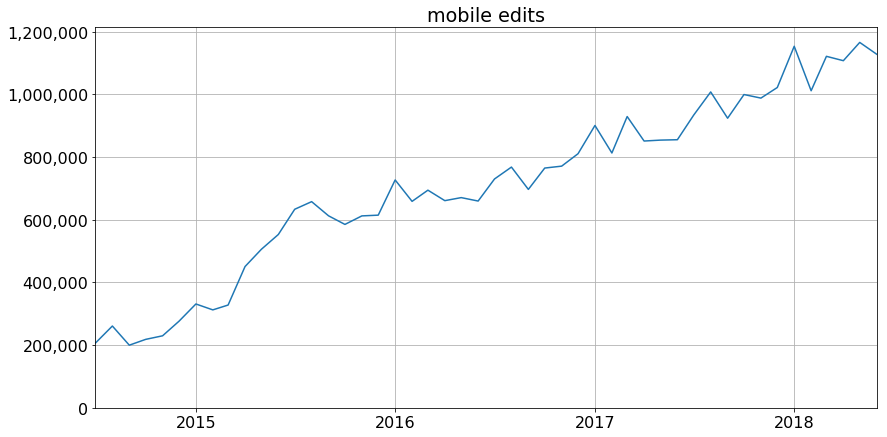

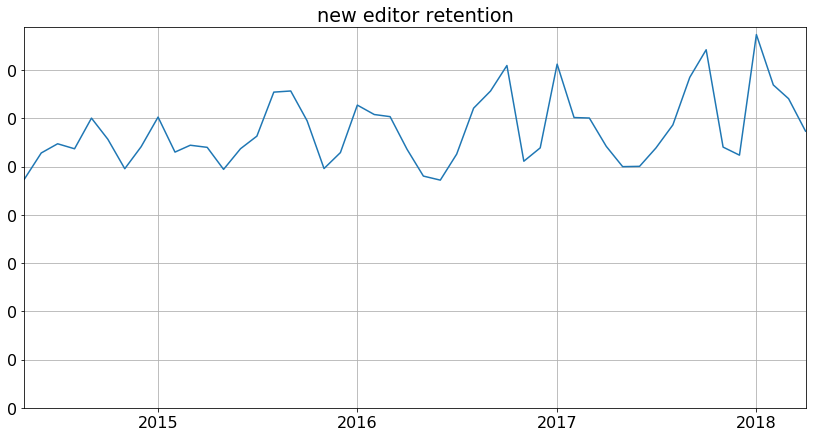

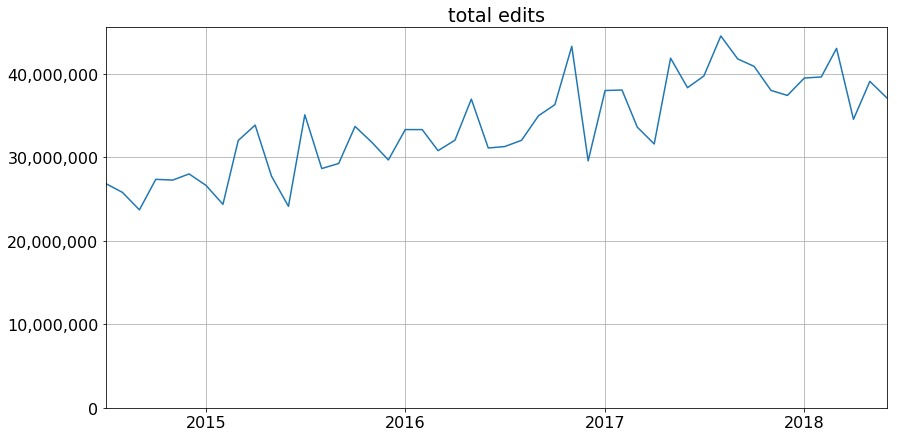

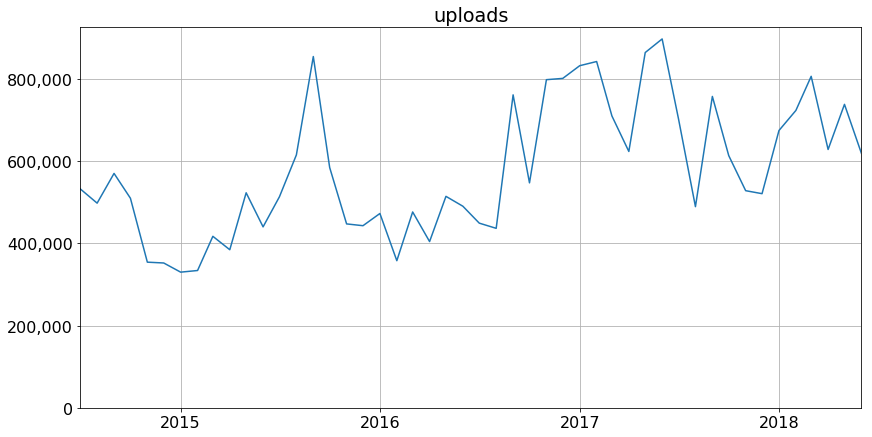

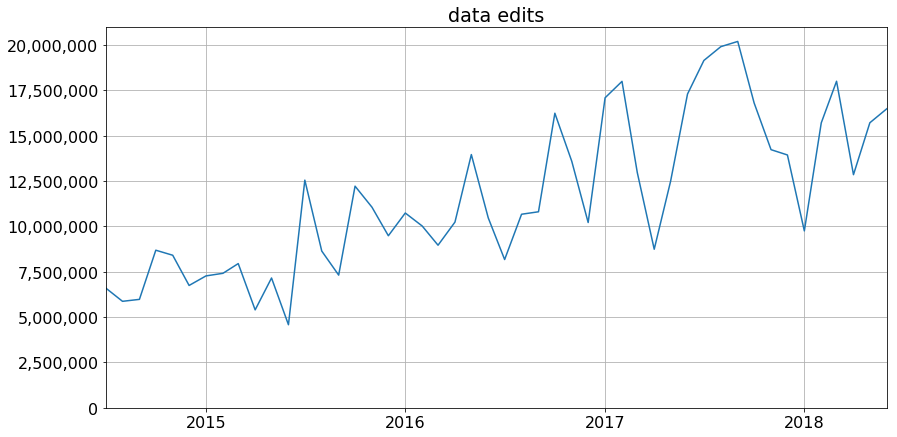

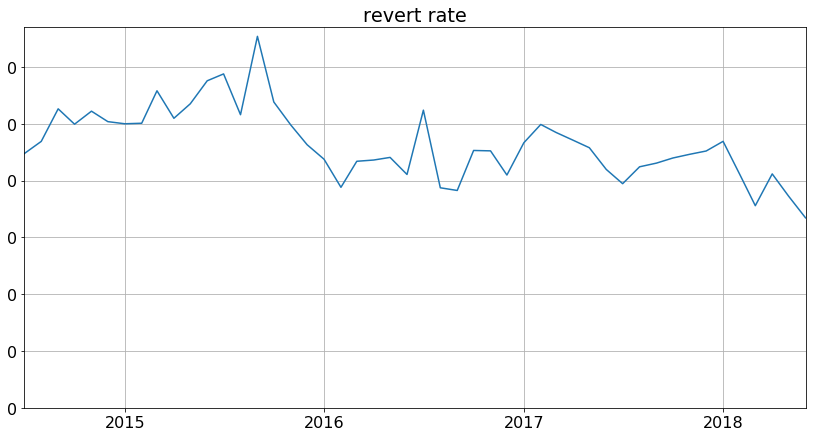

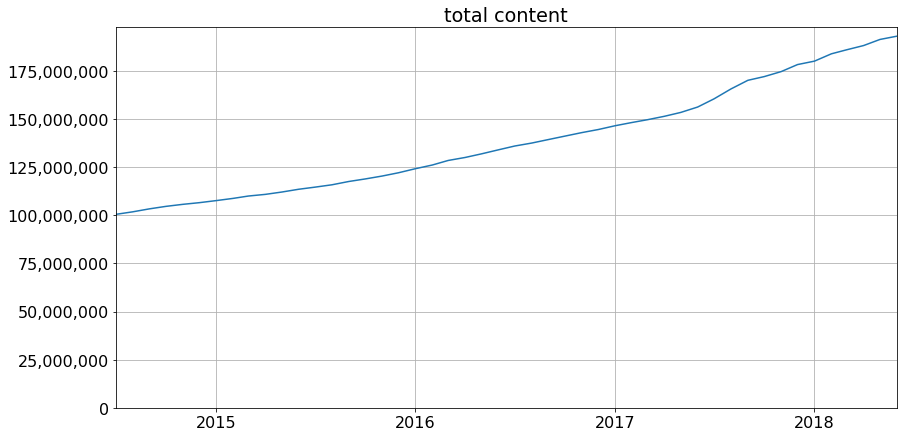

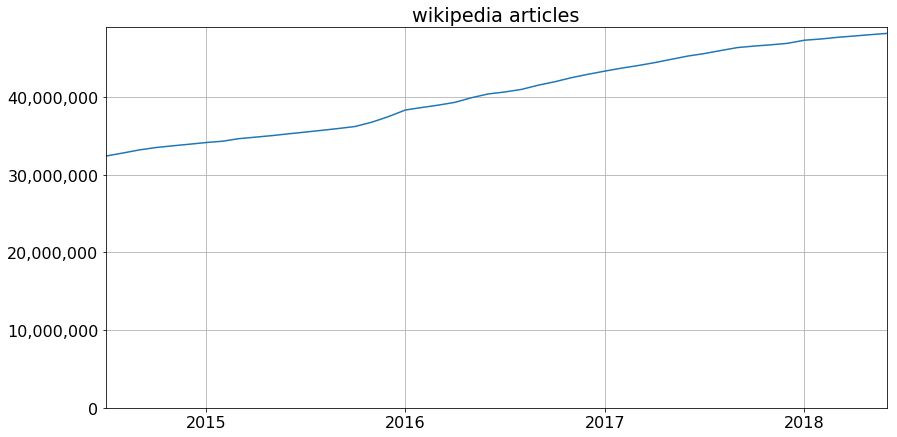

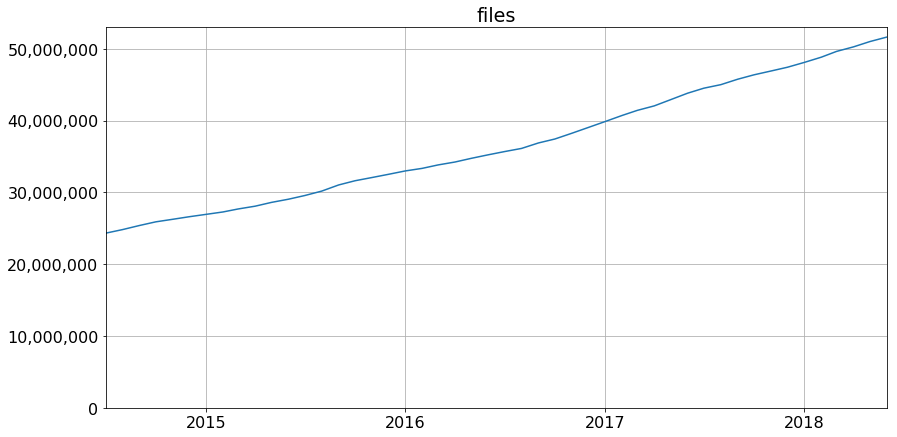

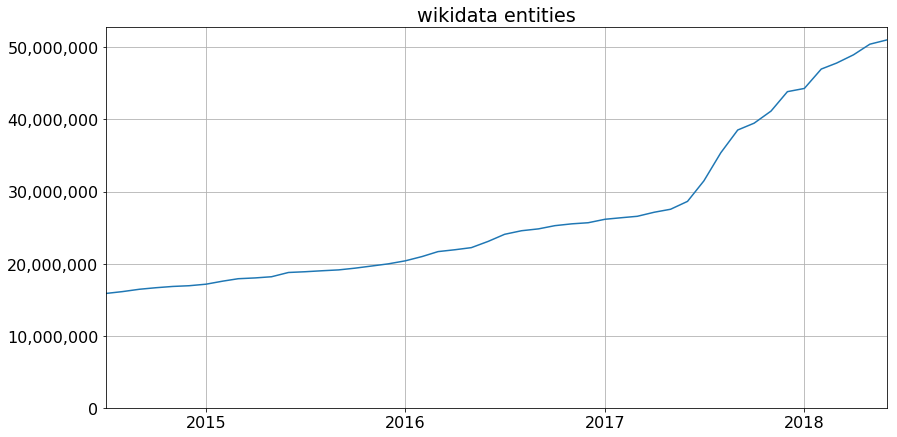

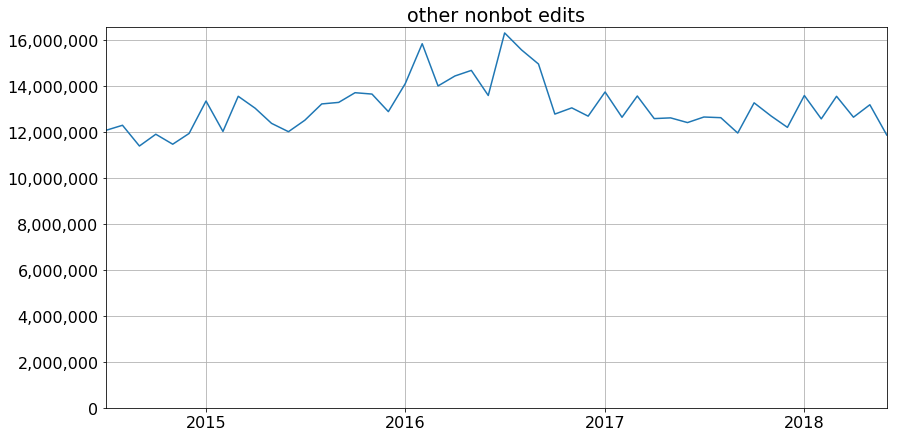

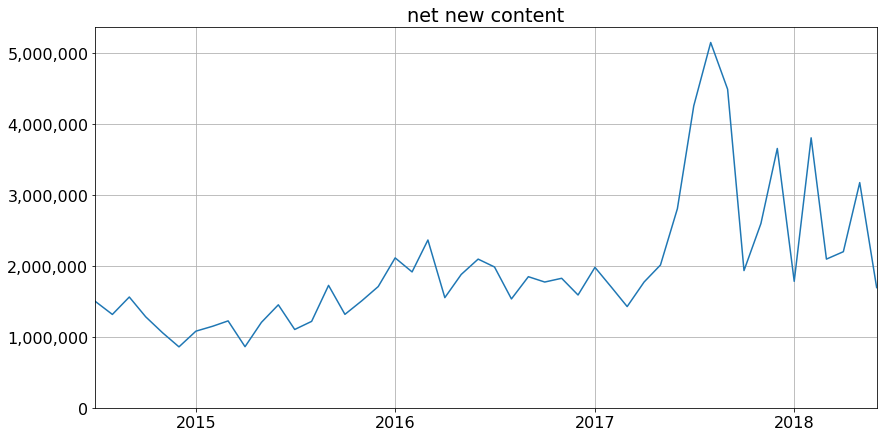

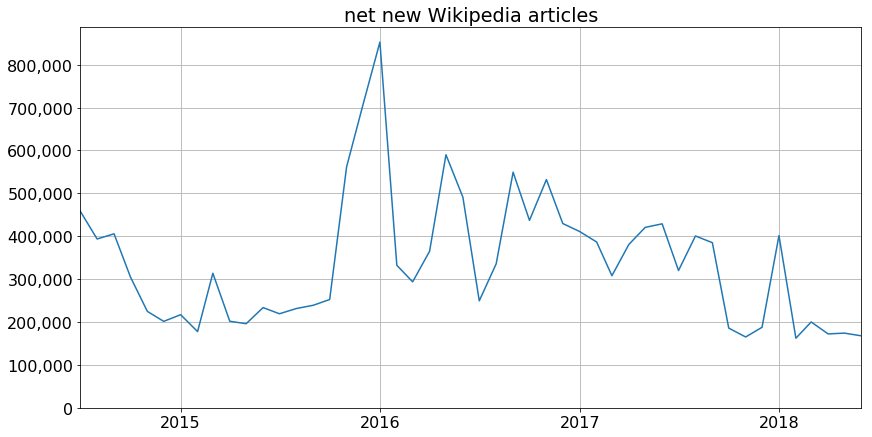

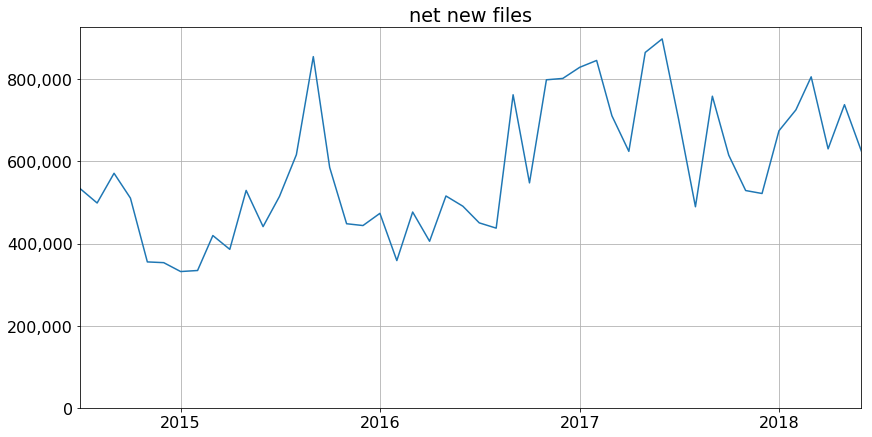

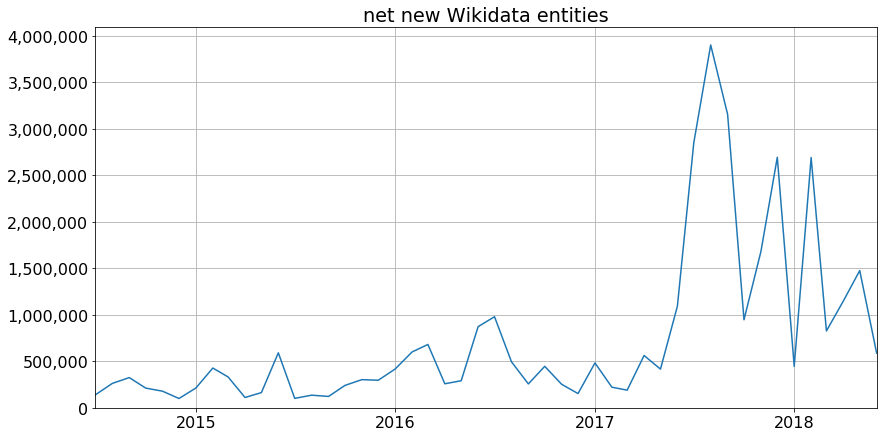

In [17]:
def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

M_fmt = mpl.ticker.FuncFormatter(M_str)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1, decimals=0)

comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "other_nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "revert_rate": {
        "y_fmt": pct_fmt
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content": {
        "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_files": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    }
}

for name, col in metrics.iteritems():
    cfg = graph_cfg.get("name", {})
    plt.figure()

    end = find_latest(col)
    start = end - relativedelta(months = 47)
    plt.plot(col[start:end])

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.gca().xaxis.set_major_locator(mpl.dates.YearLocator())
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
        
    plt.ylim(ymin=0)
    plt.autoscale(enable=True, axis="x", tight=True)